## Setup
### Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format
plt.style.use('seaborn-colorblind')

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data

In [2]:
panel_df = pd.read_csv('../data/processed/section_series_sum_small/panel.csv', index_col=['city','year'])
panel = xr.Dataset.from_dataframe(panel_df)

## Modeling
### VAR Meta Model
Run a vector autoregression for every city with 3 lags, estimating the impact of the earthquake dummy.

In [9]:
%%R
library('dynlm')
library('vars')
library('dplyr')

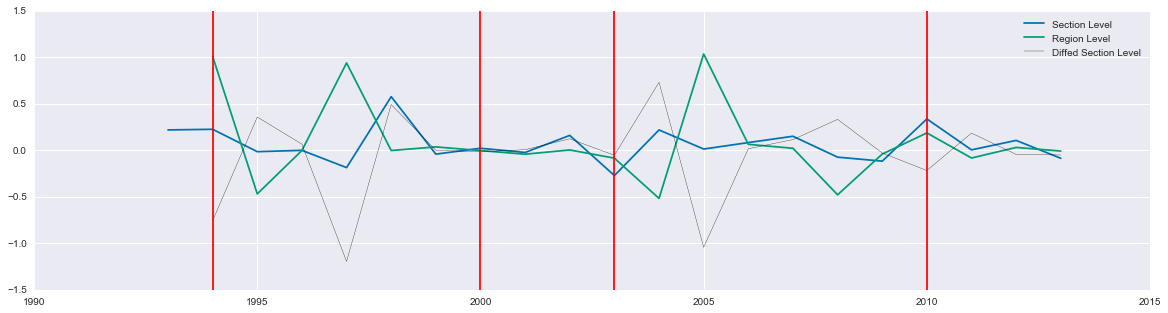

In [4]:
df = panel.sel(city='california').to_dataframe()
plt.figure(figsize=(20,5))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.region_sum_lum.pct_change(), label='Region Level')
plt.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black', lw=.3)
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')

plt.legend()
plt.show()

In [5]:
r_panel = panel_df.reset_index().dropna(axis=0)

In [6]:
(r_panel.groupby('city').sum()['earthquake_dummy'] > 0).sum()

106

In [10]:
%%R -i r_panel -o results
cities <- unique(r_panel$city)
results <- data.frame('city'=c(0),'el1'=c(0),'el2'=c(0),'el3'=c(0))

for (city in cities){
    lags = 3
    data <- r_panel[r_panel$city == city,][-lags]
    city_data <- data.frame(diff(as.matrix(data[,c('inflation','imports','exports')])))
    city_data$earthquake_dummy <- as.numeric(data$earthquake_dummy[-1])
    city_data$diff_sum_lum <- diff(data$sum_lum) - diff(data$region_sum_lum)
    var <- VAR(city_data, p=lags)
    result <- data.frame(
        'city'= c(city),
        'el1'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l1']),
        'el3'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l3']),
        'el2'= c(var$varresult$diff_sum_lum$coefficients['diff_sum_lum.l2'])
    )
    results <- rbind(results,result)
}
rownames(results) <- results$city
results <- results[c('el1','el2','el3')]

In [11]:
filtered_results = results.dropna(axis=0)

/usr/local/lib/python3.5/site-packages/pandas/types/missing.py:147: RuntimeWarning: invalid value encountered in isnan
  result = np.isnan(values)


### Average Earthquake Coefficient
Combine the earthquake lag coefficients from all the models

Average Coefficients: 
el1   -0.4088
el2   -0.3651
el3   -0.2178
dtype: float64


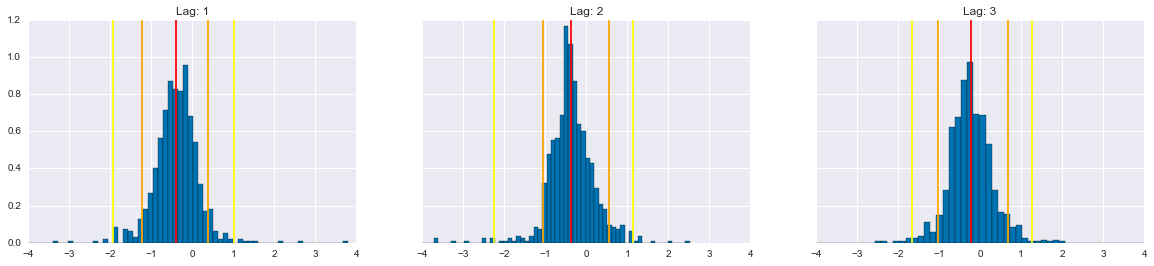

In [14]:
fig, axs = plt.subplots(1,3,figsize=(20,4), sharex=True, sharey=True)
print('Average Coefficients: \n{}'.format(filtered_results.mean()))
for i, ax in enumerate(axs.flat):
    ax.hist(filtered_results['el'+str(i+1)], bins=100, normed=True)
    ax.set_xlim([-8,8])
    ax.set_title('Lag: {}'.format(i+1))
    ax.axvline(filtered_results['el'+str(i+1)].mean(), c='r')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 5), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 95), c='orange')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 1), c='yellow')
    ax.axvline(np.percentile(filtered_results['el'+str(i+1)], 99), c='yellow')
    
plt.xlim([-4,4])
plt.savefig('../reports/figures/region_balanced_earthquake_coefficients_distribution.png')
plt.show()

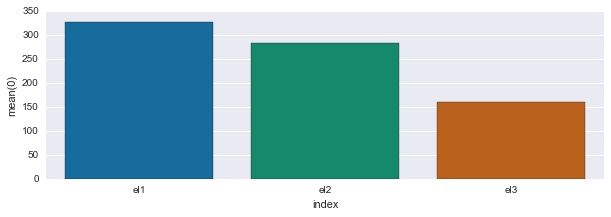

In [13]:
win_counts = filtered_results.apply(lambda r: r.argmin(), axis=1).value_counts().reset_index()
plt.figure(figsize=(10,3))
sns.barplot(x="index", y=0, data=win_counts)
plt.savefig('../reports/figures/region_balanced_earthquake_coefficients_winning_lag.png')
plt.show()